<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Deep Learning School FPMI MIPT</b></h3>

<h3 style="text-align: center;"><b>Fully Connected and Convolutional Neural Networks</b></h3>











In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Part 1. Moons dataset



In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

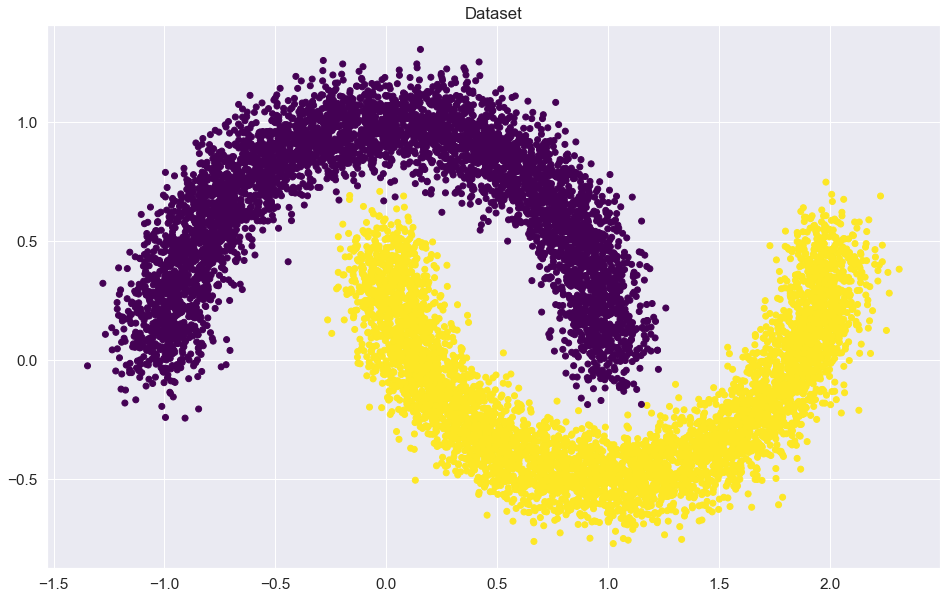

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Forming train and test sets

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Creating tensors with training and test data

In [5]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression

At the input, we have an object-feature matrix X and a column-vector $y$ - labels from $\{0, 1\}$ for each object. We want to find a weight matrix $W$ and a bias $b$ (bias) such that our $XW + b$ model will somehow predict the object's class. As you can see at the output, our model can produce a number in the range from $(-\infty;\infty)$. This output is usually called "logits" (logits). We need to transfer it to the interval from $[0;1]$ in order for it to give us the probability that the object belongs to cash register one, it is also better that this function be monotonic, quickly calculated, have a derivative and have $-\infty$ the value $0$, and on $+\infty$ it had the value $1$. Such a class of functions is called sigmoids. Most often, as a sigmoid is taken 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.Tensor(np.random.uniform(-np.sqrt(1/in_features), np.sqrt(1/in_features), size = out_features)))

    def forward(self, x):
        x =  x @ self.weights.T
        if self.bias:
            x +=  self.bias_term[None]
        return x#.flatten()

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

### Implementation of the learning cycle

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch[:,None]) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.8046875
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.8828125
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


### Visualising 

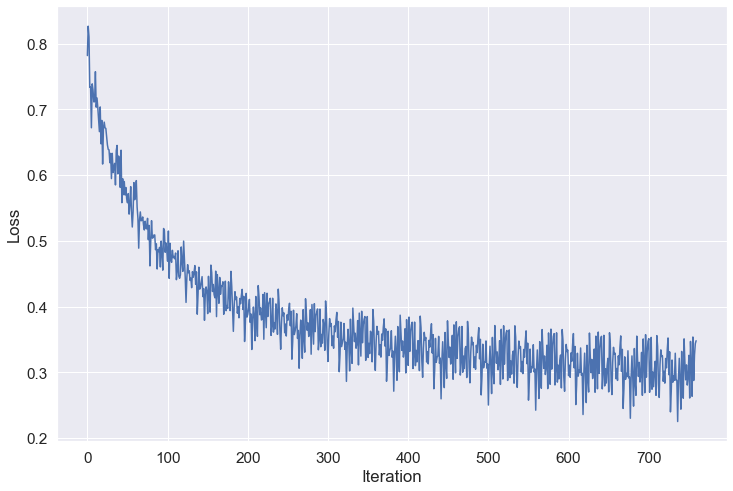

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

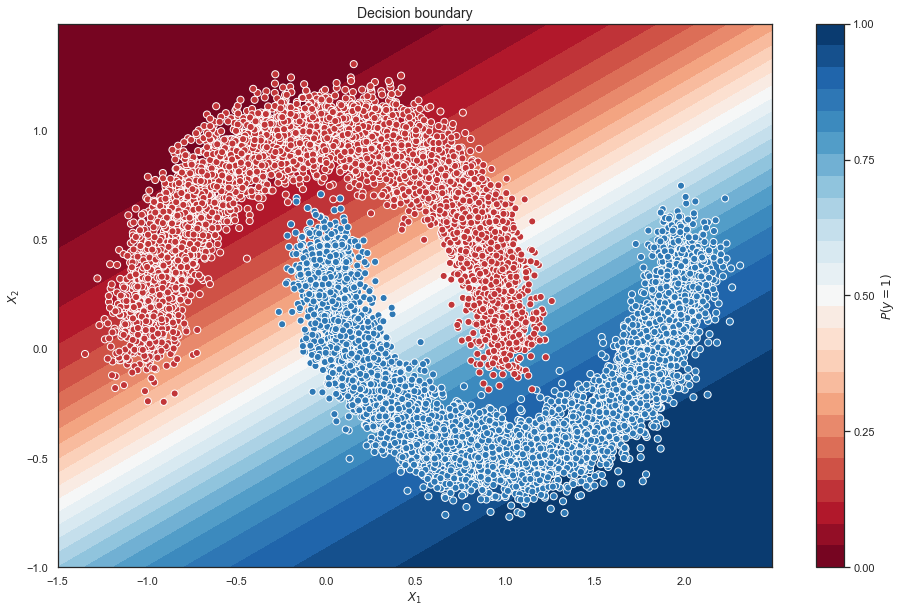

In [12]:
sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model.forward(x_batch)
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [14]:
from sklearn.metrics import accuracy_score
score = predict(val_dataloader, linear_regression)
accuracy_score(y_val, score) 

0.8636

# Part 2. MNIST dataset
The MNIST dataset contains handwritten numbers. Let's load the dataset and create DataLoaders.

In [15]:
import os
from torchvision import transforms as tfs
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

## Part 2.1. Fully Connected Neural Networks
We first solve MNIST using a fully connected neural network.

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [17]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10),
    nn.Softmax()
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()  
                with torch.no_grad(): 
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


C:\Users\amorf\anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1
Loader: train. Accuracy: 0.8231
Loader: valid. Accuracy: 0.9095
Epoch: 2
Loader: train. Accuracy: 0.9150666666666667
Loader: valid. Accuracy: 0.9238
Epoch: 3
Loader: train. Accuracy: 0.93315
Loader: valid. Accuracy: 0.9455
Epoch: 4
Loader: train. Accuracy: 0.94495
Loader: valid. Accuracy: 0.9489
Epoch: 5
Loader: train. Accuracy: 0.9539
Loader: valid. Accuracy: 0.9466
Epoch: 6
Loader: train. Accuracy: 0.9583666666666667
Loader: valid. Accuracy: 0.9587
Epoch: 7
Loader: train. Accuracy: 0.9620166666666666
Loader: valid. Accuracy: 0.9597
Epoch: 8
Loader: train. Accuracy: 0.9649
Loader: valid. Accuracy: 0.9512
Epoch: 9
Loader: train. Accuracy: 0.9670166666666666
Loader: valid. Accuracy: 0.9617
Epoch: 10
Loader: train. Accuracy: 0.96885
Loader: valid. Accuracy: 0.9674


### Activation functions test
Let's try different activation functions. For each activation function, count the validation accuracy array. We will implement this as a function that takes activation as input and receives an array of accuracies.

In [21]:
elu_accuracy = accuracy["valid"]

In [1]:
def test_activation_function(activation):
    activation = activation
    
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10),
    nn.Softmax()
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    print('\033[1m'+'Test network with '+ str(activation) + ' activation' + '\033[0m')
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()  
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()  
                    with torch.no_grad(): 
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.shape[0]
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    print('\033[1m'+'End test \n \n'+ '\033[0m')
    return accuracy["valid"]

In [23]:
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

Test network with Identical() activation
Epoch: 1
Loader: train. Accuracy: 0.83205
Loader: valid. Accuracy: 0.894
Epoch: 2
Loader: train. Accuracy: 0.8951333333333333
Loader: valid. Accuracy: 0.9017
Epoch: 3
Loader: train. Accuracy: 0.89655
Loader: valid. Accuracy: 0.8907
Epoch: 4
Loader: train. Accuracy: 0.8964166666666666
Loader: valid. Accuracy: 0.9057
Epoch: 5
Loader: train. Accuracy: 0.8993833333333333
Loader: valid. Accuracy: 0.902
Epoch: 6
Loader: train. Accuracy: 0.8987666666666667
Loader: valid. Accuracy: 0.9024
Epoch: 7
Loader: train. Accuracy: 0.8948833333333334
Loader: valid. Accuracy: 0.8743
Epoch: 8
Loader: train. Accuracy: 0.9014333333333333
Loader: valid. Accuracy: 0.9145
Epoch: 9
Loader: train. Accuracy: 0.9006833333333333
Loader: valid. Accuracy: 0.9015
Epoch: 10
Loader: train. Accuracy: 0.9031333333333333
Loader: valid. Accuracy: 0.8979
End test 
 

Test network with ReLU() activation
Epoch: 1
Loader: train. Accuracy: 0.7779333333333334
Loader: valid. Accuracy: 0.833

### Accuracy
Visulisation accuracy/epoch for each activation

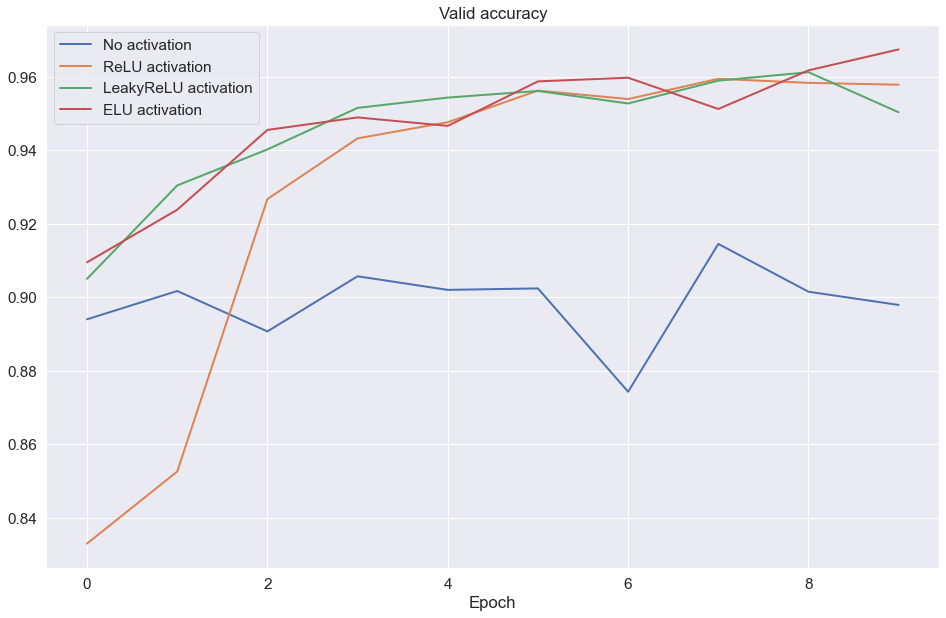

In [24]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

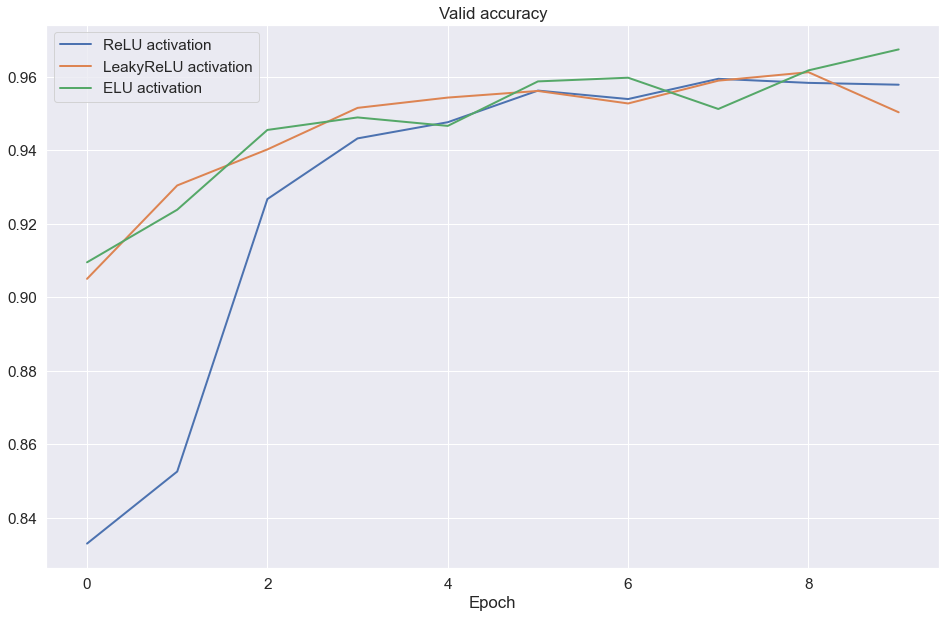

In [25]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

ELU showed the best result. Nonlinear activation functions give a similar result at the end of training, and depending on the run, each of these functions can show a better result, however, the difference can be comparable to the error and the difference of an arbitrary state of the system.

## Part 2.2 Convolutional neural networks

### Cores
First, let's work a little with the very concept of the convolution kernel.

In [26]:
#!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

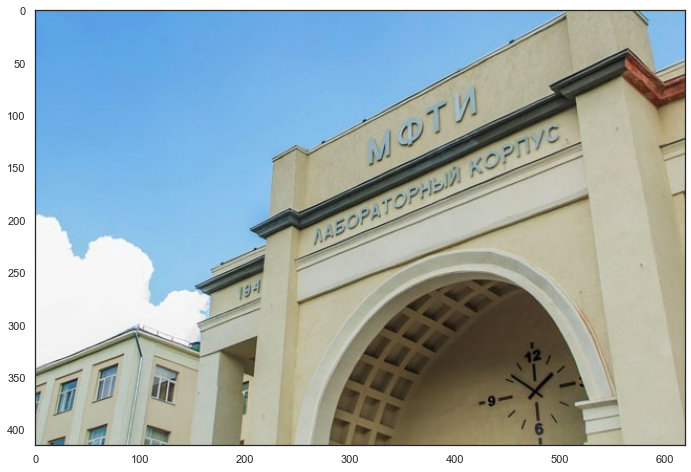

In [27]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Lets try to see how different convolutions affect the photo. For example:
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

In [46]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

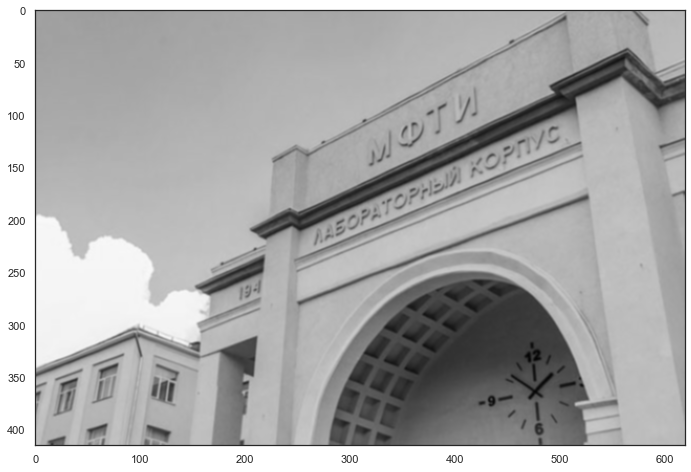

In [47]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

### LeNet realisation

In [30]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.simplify = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.simplify(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [31]:
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

Model training

In [32]:
import torch.nn.functional as F

In [33]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                optimizer.zero_grad()
                outp = model.forward(x_batch)
            else:
                model.eval()  
                with torch.no_grad(): 
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8657
Loader: valid. Accuracy: 0.9653
Epoch: 2
Loader: train. Accuracy: 0.9677666666666667
Loader: valid. Accuracy: 0.9756
Epoch: 3
Loader: train. Accuracy: 0.9778
Loader: valid. Accuracy: 0.9811
Epoch: 4
Loader: train. Accuracy: 0.9826333333333334
Loader: valid. Accuracy: 0.9829
Epoch: 5
Loader: train. Accuracy: 0.9863
Loader: valid. Accuracy: 0.9825
Epoch: 6
Loader: train. Accuracy: 0.9882833333333333
Loader: valid. Accuracy: 0.9835
Epoch: 7
Loader: train. Accuracy: 0.9898166666666667
Loader: valid. Accuracy: 0.9846
Epoch: 8
Loader: train. Accuracy: 0.9915833333333334
Loader: valid. Accuracy: 0.9845
Epoch: 9
Loader: train. Accuracy: 0.9928666666666667
Loader: valid. Accuracy: 0.985
Epoch: 10
Loader: train. Accuracy: 0.9936666666666667
Loader: valid. Accuracy: 0.9847


In [34]:
lenet_accuracy = accuracy["valid"]

Lets compare results from previous part

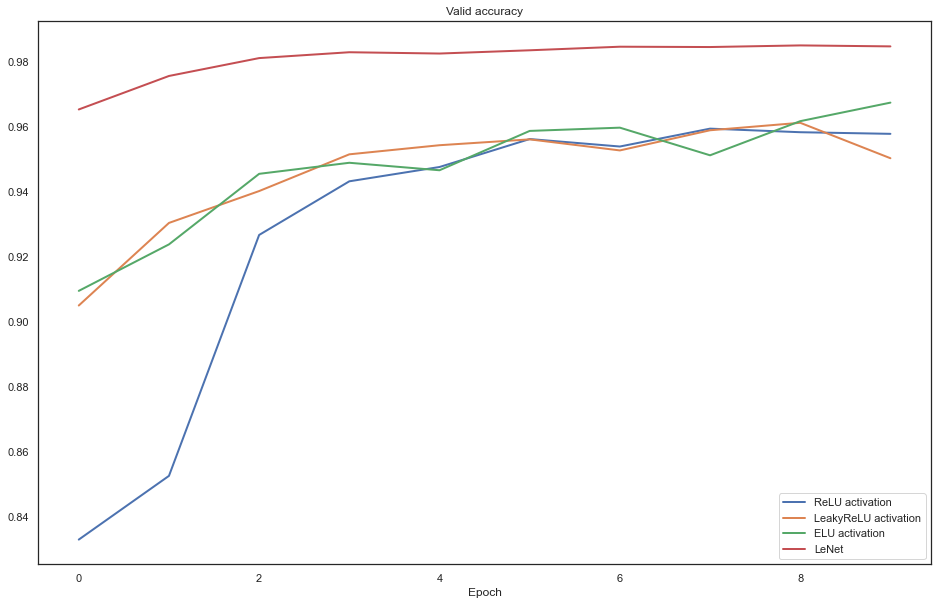

In [35]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

As we can see, convolutional NN shows more efficiency